<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/Hadith/blob/main/bow_featuring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Next

- Visualize
  - try word cloud for each class


# Loading Data

In [120]:
import pandas as pd

In [121]:
data_url = 'https://raw.githubusercontent.com/KamelGaanoun/MHDetection/main/Corpus/trainFinal.csv'

data = pd.read_csv(data_url, index_col='Unnamed: 0')
print("CSV file loaded successfully!")
# Display the first few rows of the DataFrame
data.head()

CSV file loaded successfully!


,Matan,Degree
19036,لقد رأيتني وأنا ثلث الإسلام،‏.‏,0
17209,هريرة، أن أعرابيا، أتى النبي صلى الله عليه وس...,0
11245,عائشة، قالت كنت أفتل قلائد هدى رسول الله صلى ...,0
2827,قال النبي صلى الله عليه وسلم ‏ ‏ إني فرطكم على...,0
23616,عن النبي صلى الله عليه وسلم قال أقيموا الركوع ...,0


In [122]:
print(len(data))
print(data['Degree'].value_counts())

21248
Degree
0    19286
1     1962
Name: count, dtype: int64


In [123]:
# Filter data for each degree
data_degree_0 = data[data['Degree'] == 0]
data_degree_1 = data[data['Degree'] == 1]

# Sample 200 rows from each degree (if available)
# Use .sample(n, random_state) for reproducible sampling
sampled_degree_0 = data_degree_0.sample(n=min(1962, len(data_degree_0)), random_state=42)
sampled_degree_1 = data_degree_1.sample(n=min(1962, len(data_degree_1)), random_state=42)

# Concatenate the sampled dataframes
sampled_data = pd.concat([sampled_degree_0, sampled_degree_1])

# Display the value counts to verify the sampling
print("Value counts of the sampled data:")
display(sampled_data['Degree'].value_counts())

# Display the head of the sampled data
print("\nSampled data head:")
display(sampled_data.head())

Value counts of the sampled data:


,count
Degree,
0,1962
1,1962



Sampled data head:


,Matan,Degree
13645,أنها استعارت من أسماء قلادة فهلكت فأرسل النبي ...,0
16561,يقول كان رسول الله صلى الله عليه وسلم يأتي قبا...,0
13787,هريرة، أن رسول الله صلى الله عليه وسلم قال قلب...,0
4475,أبيه، أن النبي صلى الله عليه وسلم قال لا تزال ...,0
16463,القاسم صلى الله عليه وسلم تسموا باسمي ولا تكنو...,0


In [124]:
labels = sampled_data['Degree'].values
labels.shape

(3924,)

# Preprocessing

In [125]:
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
def remove_diacritics(text):
  # remove diacritics
  text = text.replace(u"\u064B", "")  # fatHatayn
  text = text.replace(u"\u064C", "")  # Dammatayn
  text = text.replace(u"\u064D", "")  # kasratayn
  text = text.replace(u"\u064E", "")  # fatHa
  text = text.replace(u"\u064F", "")  # Damma
  text = text.replace(u"\u0650", "")  # kasra
  text = text.replace(u"\u0651", "")  # shaddah
  text = text.replace(u"\u0652", "")  # sukuun
  text = text.replace(u"\u0670", "`")  # dagger 'alif
  return text

In [127]:
sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_diacritics(hadith))

In [128]:
sampled_data['text_length'] = sampled_data['Matan'].str.len()
sampled_data['stopwords_count'] = sampled_data['Matan'].apply(lambda hadith: len([word for word in hadith.split() if word in arabic_stopwords]))
sampled_data = sampled_data.sort_values(by='text_length',ascending=[0])
sampled_data.head()

,Matan,Degree,text_length,stopwords_count
1427,لما أسري بي إلى السماء رأيت فيها أعاجيب من ع...,1,29527,1629
4106,أن جبريل عليه السلام أتى النبي صلى الله عليه...,1,9507,440
3738,زيارة إبليس اللعين للنبي صلى الله عليه وسلم...,1,9363,474
10718,أنس بن مالك رضي الله عنه قال: ((جاء جبريل إ...,1,8711,438
22047,((روي عن النبي صلى الله عليه وآله وسلم أنه ق...,1,7504,471


In [131]:
def remove_keyrings(text):
    # This regex pattern matches various keyrings like "قال رسول الله صلى الله عليه وسلم" and variations
    pattern = r'قال\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم|قال\s*صلى\s*الله\s*عليه\s*وسلم|صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|صلى\s*الله\s*عليه\s*وسلم\s*قال|وفي\s*الحديث|قال\s*رسول\s*الله\s*ص|صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*يقول|صلى\s*الله\s*عليه\s*وسلم\s*يقول|قال\s*رسول\s*الله|قال\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم|النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|قال\s*النبي|عن\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|عن\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|عن\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|عن\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*قال'
    text = re.sub(pattern, '', text)
    return text

sampled_data['Matan'] = sampled_data['Matan'].apply(remove_keyrings)

print("Keyrings removed from 'Matan' column.")
display(sampled_data.head())

Keyrings removed from 'Matan' column.


,Matan,Degree,text_length,stopwords_count
1427,لما أسري بي إلى السماء رأيت فيها أعاجيب من ع...,1,29527,1629
4106,أن جبريل عليه السلام أتى النبي صلى الله عليه...,1,9507,440
3738,زيارة إبليس اللعين للنبي صلى الله عليه وسلم...,1,9363,474
10718,أنس بن مالك رضي الله عنه قال: ((جاء جبريل إ...,1,8711,438
22047,((روي عن النبي صلى الله عليه وآله وسلم أنه ق...,1,7504,471


# Exploratory Text Analysis

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

## Top N words

In [133]:
# Separating Degrees

top_n = 20

# Filter data by degree
data_degree_0_text = sampled_data[sampled_data['Degree'] == 0]['Matan']
data_degree_1_text = sampled_data[sampled_data['Degree'] == 1]['Matan']

# Create CountVectorizer objects for each degree
vectorizer_degree_0 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1, max_df=200)
vectorizer_degree_1 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1, max_df=200)

# Transform the data for each degree
bow_degree_0 = vectorizer_degree_0.fit_transform(data_degree_0_text)
bow_degree_1 = vectorizer_degree_1.fit_transform(data_degree_1_text)

# Get feature names (words) and counts for each degree
words_degree_0 = vectorizer_degree_0.get_feature_names_out()
counts_degree_0 = bow_degree_0.sum(axis=0).A1
word_counts_0 = dict(zip(words_degree_0, counts_degree_0))
word_counts_0 = dict(sorted(word_counts_0.items(), key=lambda item: item[1], reverse=True))

words_degree_1 = vectorizer_degree_1.get_feature_names_out()
counts_degree_1 = bow_degree_1.sum(axis=0).A1
word_counts_1 = dict(zip(words_degree_1, counts_degree_1))
word_counts_1 = dict(sorted(word_counts_1.items(), key=lambda item: item[1], reverse=True))


print(f"Top {top_n} most frequent words for Degree 0:")
display(pd.DataFrame(list(word_counts_0.items())[:top_n], columns=['Word', 'Count']))

print(f"\nTop {top_n} most frequent words for Degree 1:")
display(pd.DataFrame(list(word_counts_1.items())[:top_n], columns=['Word', 'Count']))

Top 20 most frequent words for Degree 0:


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


,Word,Count
0,ابن,246
1,أبي,239
2,عبد,228
3,قالت,187
4,الناس,181
5,رجل,181
6,يقول,179
7,فلما,174
8,عمر,172
9,وقال,166



Top 20 most frequent words for Degree 1:


,Word,Count
0,علي,277
1,محمد,256
2,تعالى,227
3,النبي,222
4,جبريل,216
5,بن,213
6,القيامة,183
7,الناس,178
8,عنه,171
9,النار,168


## Word Cloud

In [ ]:
!pip install -qU arabic-reshaper python-bidi

In [134]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

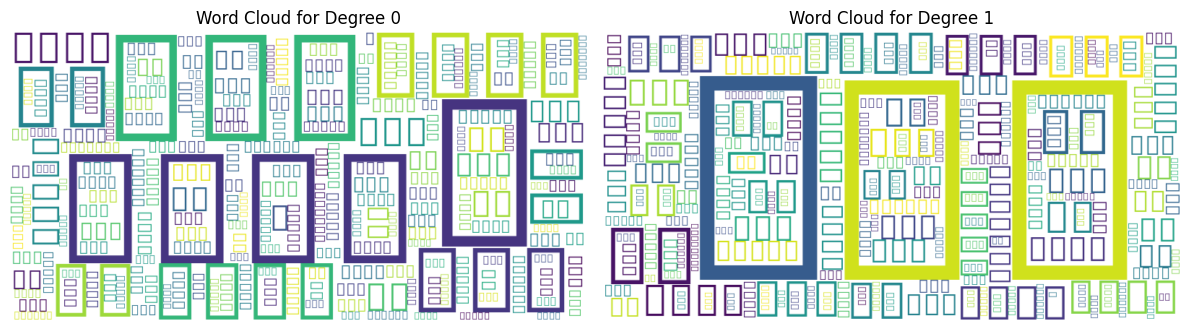

In [142]:
# Combine all text for each degree
text_degree_0 = " ".join(data_degree_0_text)
text_degree_1 = " ".join(data_degree_1_text)

# Reshape Arabic text for correct display in word cloud
reshaped_text_0 = arabic_reshaper.reshape(text_degree_0)
bidi_text_0 = get_display(reshaped_text_0)

reshaped_text_1 = arabic_reshaper.reshape(text_degree_1)
bidi_text_1 = get_display(reshaped_text_1)

# Generate word cloud for Degree 0
wordcloud_0 = WordCloud(width=800, height=400, background_color='white', stopwords=arabic_stopwords, collocations=False).generate(bidi_text_0)

# Generate word cloud for Degree 1
wordcloud_1 = WordCloud(width=800, height=400, background_color='white', stopwords=arabic_stopwords, collocations=False).generate(bidi_text_1)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Degree 0')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Degree 1')

plt.tight_layout()
plt.show()

## Comparing lengths

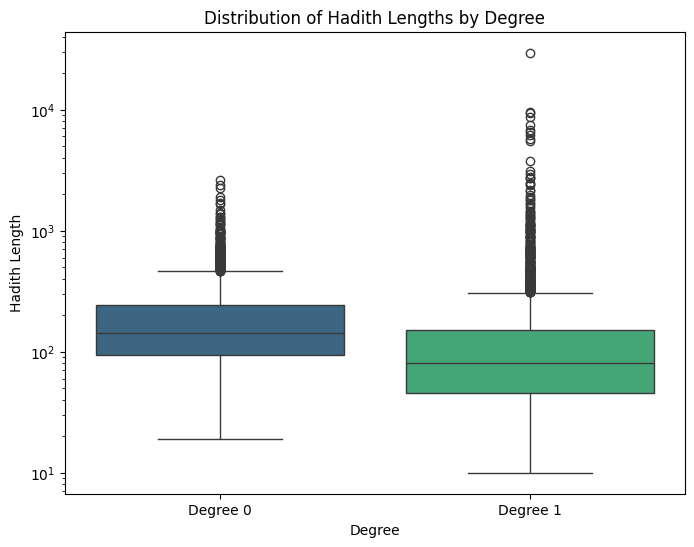

In [94]:
# Create box plots for Hadith lengths by degree
plt.figure(figsize=(8, 6))
sns.boxplot(x='Degree', y='text_length', data=sampled_data, hue='Degree', palette='viridis', legend=False)
plt.title('Distribution of Hadith Lengths by Degree')
plt.xlabel('Degree')
plt.ylabel('Hadith Length')
plt.xticks([0, 1], ['Degree 0', 'Degree 1'])
plt.yscale('log') # Scaled the y-axis logarithmically
plt.show()

In [95]:
# Calculate percentiles for text length by degree
percentiles = sampled_data.groupby('Degree')['text_length'].quantile([0.25, 0.5, 0.75])

print("Percentiles of Hadith Length by Degree:")
display(percentiles)

Percentiles of Hadith Length by Degree:


Degree      
0       0.25     94.00
        0.50    144.00
        0.75    241.75
1       0.25     46.00
        0.50     80.00
        0.75    151.00
Name: text_length, dtype: float64

In [96]:
# Calculate IQR for each degree
Q1 = sampled_data.groupby('Degree')['text_length'].quantile(0.25)
Q3 = sampled_data.groupby('Degree')['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
upper_bound = Q3 + 1.5 * IQR

print("\nUpper bounds for outliers:")
display(upper_bound)

# Identify outliers for each degree
outliers_degree_0 = sampled_data[(sampled_data['Degree'] == 0) &
                                (sampled_data['text_length'] > upper_bound[0])]

outliers_degree_1 = sampled_data[(sampled_data['Degree'] == 1) &
                                (sampled_data['text_length'] > upper_bound[1])]


# Print the number of outliers
print(f"Number of outliers for Degree 0 above upper bound: {len(outliers_degree_0)}")
print(f"Number of outliers for Degree 1 above upper bound: {len(outliers_degree_1)}")


Upper bounds for outliers:


,text_length
Degree,
0,463.375
1,308.500


Number of outliers for Degree 0 above upper bound: 146
Number of outliers for Degree 1 above upper bound: 227


# Classifiers

In [ ]:
from sklearn import metrics
import numpy as np

## Split

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
# Create a CountVectorizer Object
vectorizer = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1)

# Fit and transform the corpus
bow = vectorizer.fit_transform(sampled_data['Matan'])

# Print the length of the generated vocabulary
print("Vocabulary Size:", len(vectorizer.get_feature_names_out()))

# Print the Bag-of-Words matrix
print("BoW Representation:")
print(bow.toarray())
print(bow.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Vocabulary Size: 24379
BoW Representation:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3924, 24379)


In [99]:
X_train, X_test, y_train, y_test = train_test_split(bow, labels, test_size=0.2,random_state=109)

In [100]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3139, 24379), (785, 24379), (3139,), (785,))

## SVC

In [101]:
from sklearn.svm import LinearSVC

In [102]:
clf = LinearSVC(random_state=109)
clf.fit(X_train, y_train)

LinearSVC(random_state=109)

### Evaluation

In [105]:
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8547770700636943
Precision: 0.7951541850220264
Recall: 0.9450261780104712
F1 Score: 0.8636363636363636


In [106]:
coefficients = list(clf.coef_[0])
words = list(vectorizer.get_feature_names_out())
maximas = {}
minimas = {}

for i in range(100):
  max_value = max(coefficients)
  min_value = min(coefficients)

  mx = coefficients.index(max_value)
  maximas[words[mx]] = max_value
  coefficients.pop(mx)
  words.pop(mx)

  mn = coefficients.index(min_value)
  minimas[words[mn]] = min_value
  coefficients.pop(mn)

In [107]:
minimas.keys()

dict_keys(['زهذه', 'سأقضي', 'جهينة', 'جاءوا', 'قالتاه', 'المشرق', 'شوكا', 'عبدتك', 'فأعطاه', 'يؤذن', 'يقبلها', 'استلم', 'مكان', 'صائر', 'الملء', 'وقامة', 'أخبرنا', 'الكبير', 'يطرح', 'لمشورته', 'مغموما', 'ورواه', 'كليمك', 'تراقيهم', 'جملا', 'وبلال', 'الله', 'وفوضت', 'وإلا', 'ففعلته', 'بدينهم', 'فلست', 'الأمثال', 'وعابدهم', 'بيعكم', 'فصرخ', 'وأمركما', 'أمي', 'منعم', 'مكية', 'صل', 'والحلف', 'النخل', 'يخافون', 'فقطعه', 'المستغيثين', 'الموهبة', 'أسمائه', 'فأولتها', 'وزيارة', 'وأخذوا', 'ربى', 'رافعا', 'نعليك', 'رش', 'القتل', 'الربوي', 'شهران', 'عالم', 'والساعة', 'يغضب', 'أحدهم', 'فليعلن', 'روعاتي', 'المستودعة', 'منزلا', 'وإنهم', 'قاموا', 'يسوق', 'المقلات', 'بأصبعه', 'تستعير', 'لقائها', 'أصبعيه', 'خيلا', 'وربط', 'ولع', 'وأوشك', 'فدخلنا', 'بنسب', 'الأعصم', 'يراهما', 'الأنفحة', 'أحدكم', 'قلة', 'ذلق', 'ثناؤه', 'خصماء', 'صفاته', 'وجودنا', 'وراء', 'كفر', 'يؤنسك', 'المغفور', 'أبصارهم', 'فغر', 'السادس', 'كعدل', 'فيشفعه'])

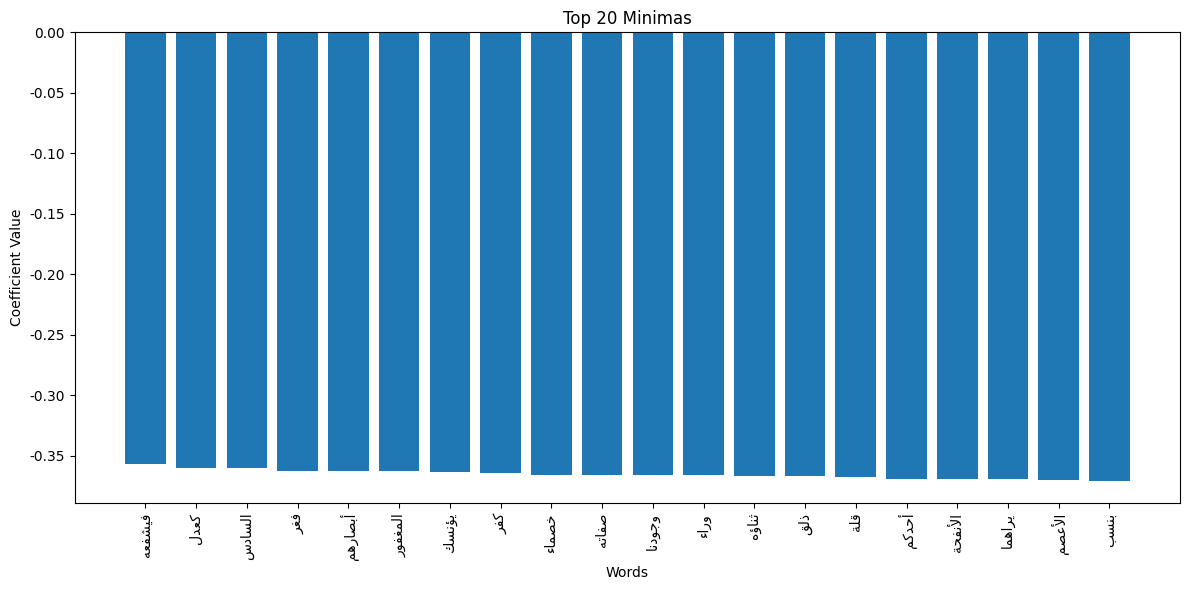

In [108]:
# Plot the coefficients for minimas
minimas = dict(sorted(minimas.items(), key=lambda item: abs(item[1]), reverse=False))

top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(minimas.keys())[:20]]

plt.figure(figsize=(12, 6))
plt.bar(top_20_words, list(minimas.values())[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Minimas')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [109]:
maximas.keys()

dict_keys(['جاؤوا', 'زهده', 'يستقوا', 'فأعطوا', 'وعماده', 'أوف', 'شهرا', 'نهدي', 'أدومه', 'نمر', 'يعلمنا', 'البرني', 'نحشر', 'انحدر', 'يموت', 'شقه', 'فألقاهن', 'خطيبا', 'وقفيزها', 'مقاعدهم', 'يهنأ', 'تمجيد', 'ففرقنا', 'فذكره', 'عشيرته', 'قضيب', 'ومثلكم', 'وتحج', 'طغيانا', 'العاقبة', 'بياقوت', 'المرضى', 'تفصيا', 'نشط', 'ركبة', 'فأفتل', 'تصدقه', 'خلفوا', 'ينقض', 'البائع', 'أنرهنك', 'إتماما', 'نصفه', 'وجلاؤها', 'بأم', 'مهران', 'يحمل', 'بشفاعتي', 'نتهمك', 'صفوفكم', 'العالم', 'لعب', 'رازق', 'فيسألونهم', 'وليت', 'فيضع', 'أولته', 'مسحتما', 'سألتني', 'أزنيت', 'شداد', 'وإدريس', 'واستعط', 'بردة', 'ضمنت', 'ضاق', 'بمغفرته', 'همام', 'أعينهم', 'مكحلين', 'ولونه', 'بعلم', 'ينسأ', 'السبى', 'الفائقة', 'يختلفوا', 'أعراضكم', 'بناتئة', 'يشأ', 'ألسنة', 'حبل', 'ترهقني', 'والجلوس', 'الصلب', 'المتلوط', 'وسماه', 'تلد', 'أمشاه', 'ناداه', 'الثمانية', 'بردائه', 'يشب', 'وعمرا', 'يؤدي', 'الخاطب', 'أسفلها', 'بأصحابي', 'تكتبها', 'سرورا', 'تؤخرون'])

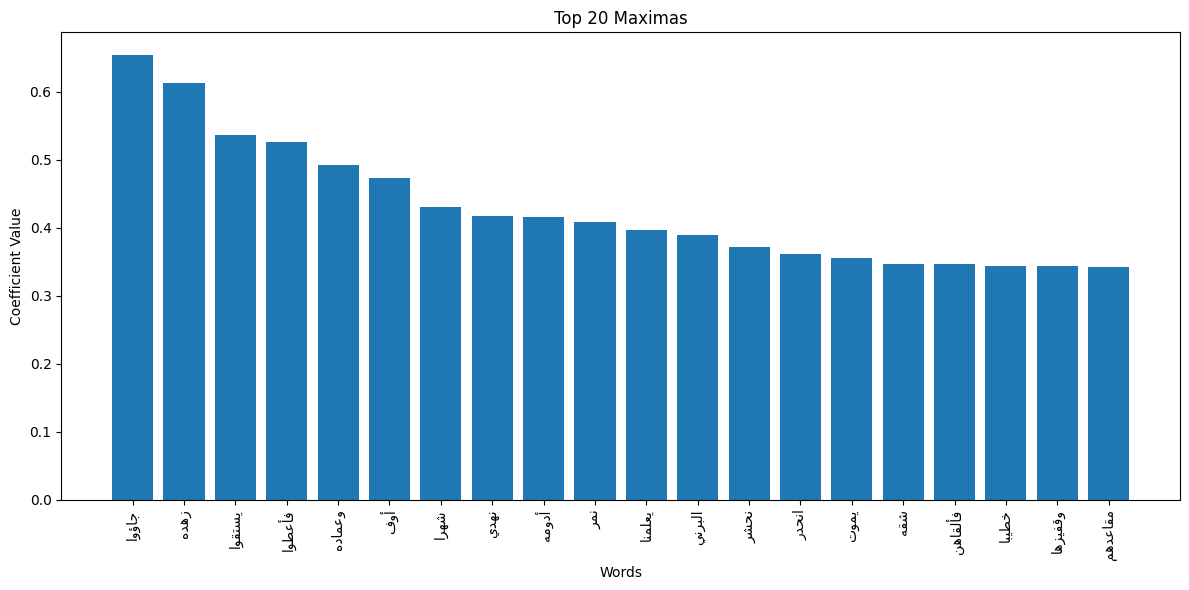

In [110]:
# Plot the coefficients for maximas
maximas = dict(sorted(maximas.items(), key=lambda item: abs(item[1]), reverse=True))

top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(maximas.keys())[:20]]

plt.figure(figsize=(12, 6))
plt.bar(top_20_words, list(maximas.values())[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Maximas')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

## Lasso Regression Model

In [111]:
from sklearn.linear_model import Lasso


Fitting Lasso model with alpha = 0.005


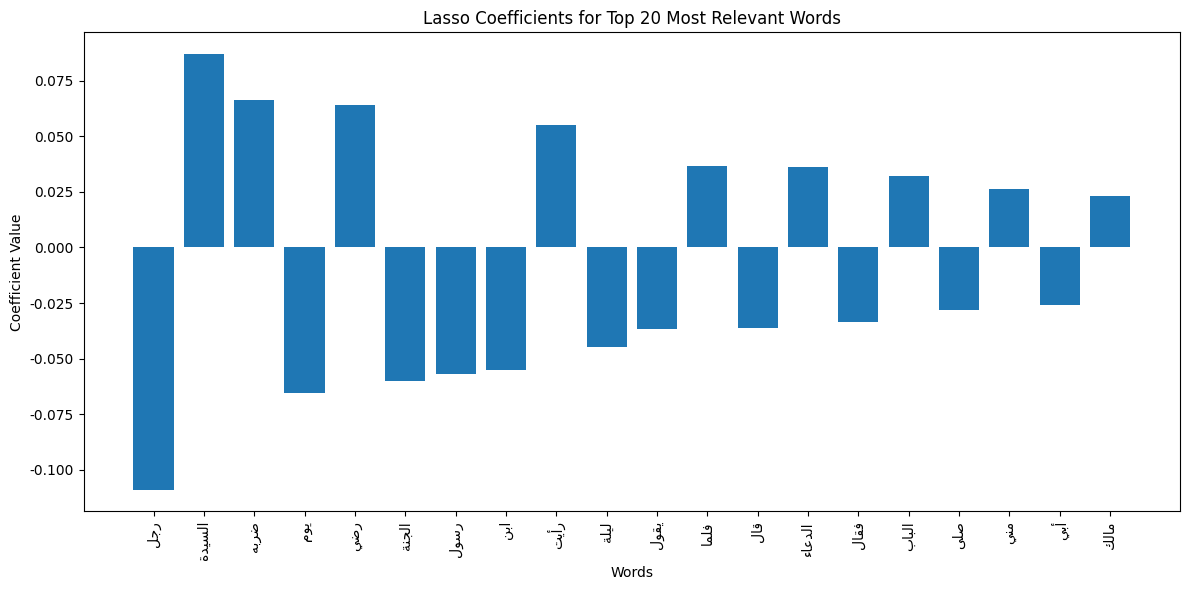


Fitting Lasso model with alpha = 0.001


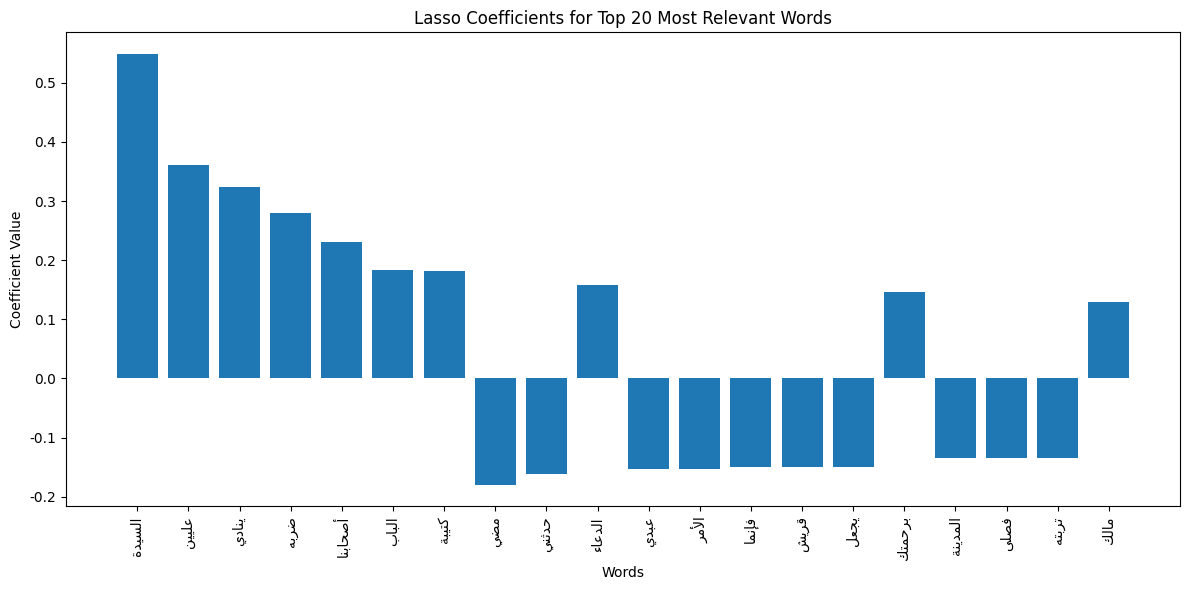

In [112]:
# Try different alpha values and observe the coefficients
alpha_values = [0.005, 0.001]
words = vectorizer.get_feature_names_out()

for alpha in alpha_values:
    print(f"\nFitting Lasso model with alpha = {alpha}")
    lasso_model = Lasso(alpha=alpha, random_state=109)
    lasso_model.fit(X_train, y_train)
    lasso_coefficients = lasso_model.coef_
    word_coefficients = dict(zip(words, lasso_coefficients))
    word_coefficients = dict(sorted(word_coefficients.items(), key=lambda item: abs(item[1]), reverse=True))

    # Plot the coefficients
    top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(word_coefficients.keys())[:20]]

    plt.figure(figsize=(12, 6))
    plt.bar(top_20_words, list(word_coefficients.values())[:20])
    plt.xticks(rotation=90)
    plt.title('Lasso Coefficients for Top 20 Most Relevant Words')
    plt.xlabel('Words')
    plt.ylabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

### Evaluation

In [113]:
y_pred_lasso = (lasso_model.predict(X_test) > 0.5).astype(int)

# Evaluate the performance of the Lasso model as a classifier
accuracy = metrics.accuracy_score(y_test, y_pred_lasso)
precision = metrics.precision_score(y_test, y_pred_lasso)
recall = metrics.recall_score(y_test, y_pred_lasso)
f1 = metrics.f1_score(y_test, y_pred_lasso)

print(f"Lasso Model Performance (as a classifier) with alpha={lasso_model.alpha}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Lasso Model Performance (as a classifier) with alpha=0.001:
Accuracy: 0.7643
Precision: 0.6848
Recall: 0.9555
F1 Score: 0.7978
